In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
Load libraries to be used in code implementation
'''
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
from csv import writer
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import multivariate_normal
from tensorflow.keras.layers import Conv1D,LSTM, Dense, Dropout,MaxPooling1D,Flatten

---


**I. DATASET**<br>
Dataset Preparation & Feature Extraction


---

In [ ]:
Fs = 16000

def load_audio(filename, Fs = 16000):
    '''
    Takes as input .wav filename and returns the floating point time series loaded using librosa
    Inputs: 
        filename: (str) filename
        Fs: (int) sampling rate in Hz
    Output: 
        x: 1D np array 
    '''
    x, sr = librosa.load(filename, sr = Fs) 
    
    return x

In [ ]:
def readDir(dirname, cat, Fs = 16000):
    '''
    Reads .wav files from directory and loads them using load_audio(); returns array of loaded audio files
                    
    Each audio file is split into 0.1s audio segments
    Inputs:
        dirname : (str) name of directory contatining . files
        cat : (int) segment of filename to be used to load specific .wav files
    Output:
        x: np array of shape (Nclips, Nsamples) Nsamples correspond to 0.1s length. Zero-padding done for shorter clips. 

    '''  
    path = dirname + '/' + cat
    files = glob.glob(path)
    
    x = []
    for file in files:
        audio = load_audio(file, Fs)
        
        #code to create 0.1s segments
        size = int(0.1*Fs)
        no_segments = audio.shape[0]//size
        for i in range(no_segments+1):
            seg = audio[i*size:(i+1)*size]
            if seg.shape[0]<size:
                seg = np.pad(seg, (0,size-seg.shape[0]))
            x.append(seg)
    
    x = np.array(x)

    return x 

In [ ]:
#load training data using readDir() 
speech = readDir('drive/MyDrive/Training Data - MLSP', cat = 'sp*.wav')
music = readDir('drive/MyDrive/Training Data - MLSP', cat = 'mu*.wav')
silence = readDir('drive/MyDrive/Training Data - MLSP', cat = 'si*.wav')
print(speech.shape)
print(music.shape)
print(silence.shape)

(3590, 1600)
(3844, 1600)
(2408, 1600)


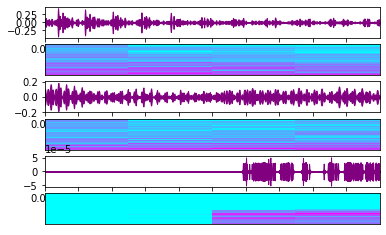

In [ ]:
'''
Visualize the spectrogram of the loaded audio files
'''
n_fft = 1024
hop_length = 512
win_length = 1024

fig, ax = plt.subplots(nrows=6)

librosa.display.waveplot(speech[0],sr=Fs, x_axis='time', color='purple',offset=0.0,ax=ax[0])
X = np.abs(librosa.stft(speech[0], n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex128))
X = librosa.power_to_db(X**2,ref=np.max)
librosa.display.specshow(X,sr=Fs, cmap='cool',hop_length=hop_length,ax=ax[1])

librosa.display.waveplot(music[0],sr=Fs, x_axis='time', color='purple',offset=0.0,ax=ax[2])
X = np.abs(librosa.stft(music[0], n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex128))
X = librosa.power_to_db(X**2,ref=np.max)
librosa.display.specshow(X,sr=Fs, cmap='cool',hop_length=hop_length,ax=ax[3])

librosa.display.waveplot(silence[0],sr=Fs, x_axis='time', color='purple',offset=0.0,ax=ax[4])
X = np.abs(librosa.stft(silence[0], n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex128))
X = librosa.power_to_db(X**2,ref=np.max)
librosa.display.specshow(X,sr=Fs, cmap='cool',hop_length=hop_length,ax=ax[5])

In [ ]:
def calc_spec(x):
  '''
  Calculates power spectrogram of audio file
  Inputs:
      x : 1D np array of loaded audio time series data
  Output:
      X : 2D np array of power spectrogram
  '''
  n_fft = 1024
  hop_length = 512
  win_length = 1024
  S = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex128))  #complex256
  X = librosa.power_to_db(S**2,ref=np.max)
  return X

In [ ]:
def audio2mfcc(x, n_mfcc = 13, Fs = 16000):    
    '''
    Computes Mel-frequency cepstral coefficients (MFCCs) from power spectrogram of audio file
    Inputs:
        x: np array of shape (Nclips, shape of power spectrogram)
        Fs: (int) sampling rate in Hz
        n_mfcc: (int) number of MFCC coefficients to be stored
    Output:
        X: (np array) MFCC sequence of each of the Nclips of power spectrograms
    '''
    X = []
    for i in range(x.shape[0]):
      S = calc_spec(x[i])
      mfcc = librosa.feature.mfcc(S = S, sr = Fs, n_mfcc = n_mfcc)
      X.append(mfcc)
  
    X = np.array(X)    

    return X 

(3590, 13, 4)
(3844, 13, 4)
(2408, 13, 4)


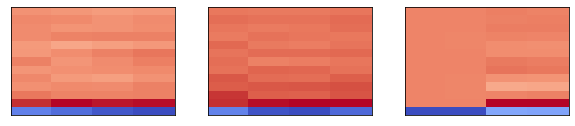

In [ ]:
#calculate MFCC features for each audio file in the dataset
sp_mfcc = audio2mfcc(speech)
mu_mfcc = audio2mfcc(music)
si_mfcc = audio2mfcc(silence)
print(sp_mfcc.shape)
print(mu_mfcc.shape)
print(si_mfcc.shape)

fig,ax = plt.subplots(figsize = (10,2),ncols = 3)
librosa.display.specshow(sp_mfcc[0],sr=Fs,ax=ax[0])
librosa.display.specshow(mu_mfcc[0],sr=Fs,ax=ax[1])
librosa.display.specshow(si_mfcc[0],sr=Fs,ax=ax[2])

In [ ]:
'''
Create training dataset.

X : (np array) MFCC feature data for each audio clip concatenated

y_sp: (np array) speech dataset labels [0]
y_mu: (np array) music dataset labels [1]
y_si: (np array) silence dataset labels [2]

y: (np array) All labels concatenated together
'''
#features
X = np.concatenate((sp_mfcc,mu_mfcc,si_mfcc))

#labels
y_sp = np.array([0]*sp_mfcc.shape[0])
y_mu = np.array([1]*mu_mfcc.shape[0])
y_si = np.array([2]*si_mfcc.shape[0])

y = np.concatenate((y_sp,y_mu,y_si))

print(X.shape)
print(y.shape)
print(y[:5])

(9842, 13, 4)
(9842,)
[0 0 0 0 0]


In [ ]:
# separate training data for GMM model training
X_speech = sp_mfcc
X_music = mu_mfcc
X_silence = si_mfcc

In [ ]:
def splitData(X, y, testFraction=0.2, randomize = True):
    """
    Splits the data randomly into training and test sets
    Inputs:
        X: (np array of len Nclips) input feature vectors
        t: (np array of len Nclips) targets; one hot vectors
        testFraction: (float) Nclips_test = testFraction * Nclips
        randomize: (bool) Randomly split data or in given order
    Outputs:
        X_train: (np array) training set features
        X_test: (np array) test set features
        t_train: (np array) training labels
        t_test: (np array) test labels
    """
    indices = np.random.permutation(X.shape[0])
    n_test = int(testFraction*X.shape[0])
    training_idx, test_idx = indices[:-n_test], indices[-n_test:]
    X_train = np.array(X[training_idx,:])
    X_test = np.array(X[test_idx,:])
    y_train = np.array(y[training_idx])
    y_test = np.array(y[test_idx])   
    
    return X_train, y_train, X_test, y_test

In [132]:
X = normalize_linear(X)

In [133]:
#Split training data using splitData()
X_train, y_train, X_test, y_test = splitData(X,y)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7874, 13, 4) (7874,) (1968, 13, 4) (1968,)


---


**II. AUDIO CLASSICATION MODELS**<br>


1.   Digital Signal Processing(DSP) Method
2.   Linear Classifier Model
3.   Convolutional Neural Network(CNN) Model
4.   Recurrent Neural Network(RNN) Model
5.   Gaussian Mixture Model(GMM)




---

**1. Digital Signal Processing(DSP) Method**

In [ ]:
#For the Speech samples
samplingFreq = 16000 
w0 = 2*np.pi*2000 # pole frequency (rad/s) #2KHz is taken as the cutoff frequency
dt = 1.0/samplingFreq 

# Low-pass filter
low_num = np.array([w0*dt/(2+w0*dt),w0*dt/(2+w0*dt)]) #the coefficients of the first order Low-Pass Filter
low_denom = np.array([(2-w0*dt)/(2+w0*dt)])
Power_low = np.zeros(len(speech))

for i in range(speech.shape[0]):
    y = speech[i]
    # Filter the signal
    yfilt_low = np.zeros(len(y))
    for j in range(3,len(y)):
        yfilt_low[j] = low_denom[0]*yfilt_low[j-1] + low_num[0]*y[j] + low_num[1]*y[j-1] #The Discrete Update
    Power_low[i] =  np.sum(np.square(yfilt_low))/len(yfilt_low)

#High-Pass Filter
high_num = np.array([2/(w0*dt+2),-2/(w0*dt+2)]) #the coefficients of the first order High-Pass Filter
high_denom = np.array([(2-w0*dt)/(2+w0*dt)])
Power_high = np.zeros(len(speech))

for i in range(speech.shape[0]):
    y = speech[i]
    yfilt_high = np.zeros(len(y))
    for j in range(3,len(speech[0])):
        yfilt_high[j] = high_denom[0]*yfilt_high[j-1] + high_num[0]*y[j] + high_num[1]*y[j-1]
    Power_high[i] = np.sum(np.square(yfilt_high))/len(yfilt_high)



#Predictions ; #Ratio Threshold : 10 # a certain ration threshold Speech will have higher value of ratio of (Power through a LPF/Power through a HPF) & Music will have a lower value
Ratio = np.zeros(len(speech))
for i in range(speech.shape[0]):
    if(Power_high[i]!=0):
        Ratio[i] = Power_low[i]/Power_high[i]

Correct_speech = Ratio>10
print(np.sum(Correct_speech))

2250


In [ ]:
def normalize_linear(x):
  '''
  Normalize the dataset
  '''
  mean = np.mean(x)
  std = np.std(x)
  x = (x-mean)/std
  return x

In [ ]:
#For the Music Samples
samplingFreq = 16000 
w0 = 2*np.pi*2000 # pole frequency (rad/s)
dt = 1.0/samplingFreq

# Low-pass filter
low_num = np.array([w0*dt/(2+w0*dt),w0*dt/(2+w0*dt)]) 
low_denom = np.array([(2-w0*dt)/(2+w0*dt)])
Power_low = np.zeros(len(music))

for i in range(music.shape[0]):
    y = music[i]
    # Filter the signal
    yfilt_low = np.zeros(len(y))
    for j in range(3,len(y)):
        yfilt_low[j] = low_denom[0]*yfilt_low[j-1] + low_num[0]*y[j] + low_num[1]*y[j-1]
    Power_low[i] =  np.sum(np.square(yfilt_low))/len(yfilt_low)

#High-Pass Filter
high_num = np.array([2/(w0*dt+2),-2/(w0*dt+2)])
high_denom = np.array([(2-w0*dt)/(2+w0*dt)])
Power_high = np.zeros(len(music))

for i in range(music.shape[0]):
    y = music[i]
    yfilt_high = np.zeros(len(y))
    for j in range(3,len(music[0])):
        yfilt_high[j] = high_denom[0]*yfilt_high[j-1] + high_num[0]*y[j] + high_num[1]*y[j-1]
    Power_high[i] = np.sum(np.square(yfilt_high))/len(yfilt_high)



#Predictions ; #Ratio Threshold : 10
Ratio = np.zeros(len(music))
for i in range(music.shape[0]):
    if(Power_high[i]!=0):
        Ratio[i] = Power_low[i]/Power_high[i]

Correct_Music = Ratio<10
print(np.sum(Correct_Music))

1773


In [ ]:
Accuracy = (np.sum(Correct_speech) + np.sum(Correct_Music))/(speech.shape[0] + music.shape[0])
print(Accuracy*100)

54.116222760290555


**2. Linear Classifier Model**

In [ ]:
def splitData_linear(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nclips) input feature vectors
        t: (np array of len Nclips) targets; one hot vectors
        testFraction: (float) Nclips_test = testFraction * Nclips
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """
    combined = np.hstack((X,t))
    #print(combined.shape)
    if(randomize):  
        np.random.shuffle(combined)
    t = combined[:,-2:]
    X = combined[:,0:combined.shape[1]-2]

    train_size_X = int((1-testFraction)*len(X))
    X_train = X[0:train_size_X]
    t_train = t[0:train_size_X]
    X_test = X[train_size_X:]
    t_test = t[train_size_X:]

    ### WRITE YOUR CODE HERE - 5 MARKS

    
    return X_train, t_train, X_test, t_test

In [ ]:
X_lin = np.concatenate((speech,music))
print(X_lin.shape)

(7434, 1600)


In [ ]:
Y_lin_music = np.array([[0,1]]*len(music))
Y_lin_speech = np.array([[1,0]]*len(speech))
Y_lin = np.concatenate((Y_lin_speech,Y_lin_music))
print(Y_lin.shape)

X_train_lin, y_train_lin, X_test_lin, y_test_lin = splitData_linear(X_lin,Y_lin)
print(X_train_lin.shape)
print(y_train_lin.shape)

(7434, 2)
(5947, 1600)
(5947, 2)


In [ ]:
x_train_lin = audio2mfcc(X_train_lin)  

In [ ]:
class Classifier: 
    '''
    Create a linear classifier to classify each frame
    '''
    def __init__(self):
        # defined model parameters here
        self.W = np.array([0])
        self.b = 0
        
    def train(self,x_train, y_train):
        '''
        Train the linear classifier
        Inputs:
            x_train: training set
            y_train: training labels
        Output:
            None
        '''
        N_clips = x_train.shape[0]
        n_mfcc = x_train[0].shape[0]
        N_frames = x_train[0].shape[1]

        x_train = normalize_linear(x_train)

        self.W = np.zeros((n_mfcc,2))
        self.b = 0
        learning_rate_aplha = 0.001

        for i in range(N_clips):
            X = x_train[i]
            Y = y_train[i].reshape((2,1))
            Y = np.tile(Y,N_frames)
            for iter in range(10000):

                Z = np.dot(self.W.T,X) + self.b
                A = 1/(1 + np.exp(-Z))

                cost = -1/N_frames*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))

                dW = (1/N_frames)*np.dot(A-Y,X.T)
                db = (1/N_frames)*np.sum(A-Y)

                self.W = self.W-learning_rate_aplha*dW.T
                self.b = self.b-learning_rate_aplha*db

                if(iter%1000==0):
                   print("cost after ", iter, "iterations is ", cost)
                if(np.isnan(cost)):
                    break    
            if(cost < 1e-5):
                break
  
        return 
    
    def save_model(self, save_path):
        '''
        Save the trained model on local disk
        Input:
            save_path: location at which model is to be saved
        Output:
            None
        '''
        np.save(save_path + "/data.npy", self.W)
            
        return
    
    def load_model(self, load_path):
        '''
        Save the trained model on local disk
        Input:
            load_path: location from which model is to be loaded
        Output:
            None
        '''
        self.W = np.load(load_path + "/data.npy")   
        return


    
    def predict_framewise(self,x_test):
        '''
        Framewise classification (speech or music)
        Input:
            x_test: test set
        Output:
            y_pred_framewise = framewise prediction
        '''
        N_clips = x_test.shape[0]
        n_mfcc = x_test[0].shape[0]
        N_frames = x_test[0].shape[1]

        Y_pred = []
        x_test = normalize(x_test)
        for i in range(N_clips):
            X = x_test[i]
            y_pred = np.dot(self.W.T,X) + self.b
            Y_pred.append(y_pred)

        Y_pred = np.array(Y_pred)
        Y_pred = Y_pred.reshape((N_clips,2,N_frames))

        y_pred_framewise = Y_pred    


  
        return Y_pred
    
    def predict_aggregate(self,y_pred_framewise):
        '''
        Aggregate frames to give a single class label (music or speech) to the entire audio file
        Input:
            y_pred_framewise = framewise prediction
        Output:
            y_hat = frame aggregate (one-hot vectors)
        '''
        y_hat = []
        N_clips = y_pred_framewise.shape[0]
        for i in range(N_clips):
            y_pred = y_pred_framewise[i]
            y_mean = np.mean(y_pred,axis = 1)
            result = np.argmax(y_mean)
            if result == 0:
                y_hat.append([1,0])
            else:
                y_hat.append([0,1])
        y_hat = np.array(y_hat)
        y_hat = y_hat.reshape((N_clips,2))        


        return y_hat

In [ ]:
model = Classifier()
model.train(x_train_lin,y_train_lin)

cost after  0 iterations is  1.3862943611198906
cost after  1000 iterations is  0.1757435187671236
cost after  2000 iterations is  0.0877925614290124
cost after  3000 iterations is  0.05812274207912416
cost after  4000 iterations is  0.043364452205012755
cost after  5000 iterations is  0.0345607116394822
cost after  6000 iterations is  0.028720411652786184
cost after  7000 iterations is  0.024565576673855456
cost after  8000 iterations is  0.02145974833075065
cost after  9000 iterations is  0.019050714976453643
cost after  0 iterations is  0.024340469208462143
cost after  1000 iterations is  0.021684586782647508
cost after  2000 iterations is  0.019552066721337892
cost after  3000 iterations is  0.017802189284882475
cost after  4000 iterations is  0.016340494560108988
cost after  5000 iterations is  0.0151012296432458
cost after  6000 iterations is  0.014037219906397322
cost after  7000 iterations is  0.013113743877027472
cost after  8000 iterations is  0.012304680367828216
cost after 

In [ ]:
x_test_lin = audio2mfcc(X_test_lin) 
y_pred_lin = model.predict_framewise(x_test_lin)   # y_predict: (Nclips, 2, N_frames)
y_hat_lin = model.predict_aggregate(y_pred_lin)    # y_hat: (Nclips, 2)

In [ ]:
def computeCM(y, y_hat):
    '''
    Compute confusion matrix to evaluate your model
    Inputs:
        y = labels 
        y_hat = predicted output
    Output:
        confusion matrix: confusion matrix
    '''
    classes = np.unique(y)
    confusion_matrix = np.zeros((len(classes),len(classes)))
    
    for i in range(len(classes)):
       for j in range(len(classes)):
          confusion_matrix[i][j] = np.sum((y == classes[i]) & (y_hat == classes[j]))   

    return confusion_matrix 

In [ ]:
confusion_matrix = computeCM(y_test_lin, y_hat_lin) 
print(confusion_matrix) 

[[   0. 1487.]
 [1487.    0.]]


In [144]:
model.save_model("/content/drive/MyDrive/Training Data - MLSP/Saved Models/Linear_Model/")
np.save('weights.npy',model.W)

**3.   Convolutional Neural Network(CNN) Model**


In [134]:
#CNN Model 
input_shape = (13,4)
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv1D(128,3,activation = 'relu',input_shape = input_shape))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64,activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(3,activation='softmax'))
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 11, 128)           1664      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 128)            0         
                                                                 
 flatten_2 (Flatten)         (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                41024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

In [135]:
cnn_model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy', metrics=['acc'])

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="acc",patience=4),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=3)]

In [136]:
history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=4,validation_data=(X_test, y_test),callbacks=my_callbacks)

Epoch 1/30
1969/1969 [==============================] - 6s 3ms/step - loss: 0.4903 - acc: 0.7339 - val_loss: 0.4190 - val_acc: 0.7688 - lr: 0.0010
Epoch 2/30
1969/1969 [==============================] - 5s 2ms/step - loss: 0.4055 - acc: 0.7955 - val_loss: 0.3633 - val_acc: 0.8257 - lr: 0.0010
Epoch 3/30
1969/1969 [==============================] - 5s 2ms/step - loss: 0.3753 - acc: 0.8118 - val_loss: 0.3349 - val_acc: 0.8491 - lr: 0.0010
Epoch 4/30
1969/1969 [==============================] - 5s 2ms/step - loss: 0.3545 - acc: 0.8330 - val_loss: 0.3154 - val_acc: 0.8674 - lr: 0.0010
Epoch 5/30
1969/1969 [==============================] - 5s 2ms/step - loss: 0.3330 - acc: 0.8471 - val_loss: 0.3100 - val_acc: 0.8720 - lr: 0.0010
Epoch 6/30
1969/1969 [==============================] - 5s 3ms/step - loss: 0.3166 - acc: 0.8567 - val_loss: 0.2732 - val_acc: 0.8714 - lr: 0.0010
Epoch 7/30
1969/1969 [==============================] - 5s 2ms/step - loss: 0.3014 - acc: 0.8659 - val_loss: 0.3143 - 

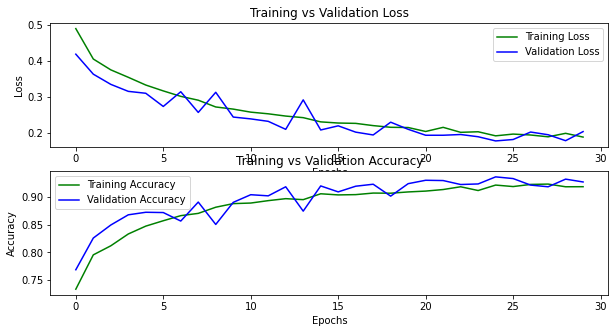

In [137]:
#plot accuracy vs epochs and loss vs epochs 
hist = history.history

tr_loss = hist['loss']
tr_acc = hist['acc']
val_loss = hist['val_loss']
val_acc = hist['val_acc']
iterations = range(len(hist['loss']))

fig,ax = plt.subplots(nrows = 2,figsize=(10,5))
ax[0].plot(iterations,tr_loss,'g-',label='Training Loss')
ax[0].plot(iterations,val_loss,'b-',label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training vs Validation Loss')
ax[0].legend()

ax[1].plot(iterations,tr_acc,'g-',label='Training Accuracy')
ax[1].plot(iterations,val_acc,'b-',label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training vs Validation Accuracy')
ax[1].legend()
plt.show()

In [138]:
#save models
cnn_model.save('/content/drive/MyDrive/Training Data - MLSP/Saved Models/CNN/final_model/')
cnn_model.save('/content/drive/MyDrive/Training Data - MLSP/Saved Models/CNN/final_model/cnn_model.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Training Data - MLSP/Saved Models/CNN/final_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Training Data - MLSP/Saved Models/CNN/final_model/assets


**4. Recurrent Neural Network(RNN) Model**

In [145]:
#RNN model
input_shape = (13,4)
rnn_model = tf.keras.Sequential()
rnn_model.add(LSTM(32,input_shape = input_shape))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(64,activation='relu'))
rnn_model.add(Dropout(0.4))
rnn_model.add(Dense(3,activation='softmax'))
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4736      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 7,043
Trainable params: 7,043
Non-trainable params: 0
_________________________________________________________________


In [146]:
rnn_model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy', metrics=['acc'])

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="acc",patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=3)]

In [147]:
history = rnn_model.fit(X_train, y_train, epochs=30, batch_size=12,validation_data=(X_test, y_test),callbacks=my_callbacks)

Epoch 1/30
657/657 [==============================] - 8s 10ms/step - loss: 0.7447 - acc: 0.5714 - val_loss: 0.5757 - val_acc: 0.6479 - lr: 0.0010
Epoch 2/30
657/657 [==============================] - 6s 8ms/step - loss: 0.5724 - acc: 0.6344 - val_loss: 0.5343 - val_acc: 0.6418 - lr: 0.0010
Epoch 3/30
657/657 [==============================] - 6s 8ms/step - loss: 0.5492 - acc: 0.6391 - val_loss: 0.5325 - val_acc: 0.6880 - lr: 0.0010
Epoch 4/30
657/657 [==============================] - 5s 8ms/step - loss: 0.5307 - acc: 0.6638 - val_loss: 0.5081 - val_acc: 0.7134 - lr: 0.0010
Epoch 5/30
657/657 [==============================] - 5s 8ms/step - loss: 0.5161 - acc: 0.7019 - val_loss: 0.4727 - val_acc: 0.7363 - lr: 0.0010
Epoch 6/30
657/657 [==============================] - 5s 8ms/step - loss: 0.4924 - acc: 0.7272 - val_loss: 0.4694 - val_acc: 0.7520 - lr: 0.0010
Epoch 7/30
657/657 [==============================] - 5s 8ms/step - loss: 0.4665 - acc: 0.7596 - val_loss: 0.4588 - val_acc: 0.77

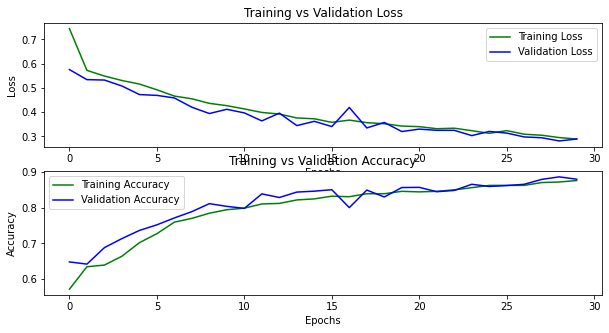

In [149]:
#plot accuracy vs epochs and loss vs epochs
hist = history.history

tr_loss = hist['loss']
tr_accuracy = hist['acc']
val_loss = hist['val_loss']
val_accuracy = hist['val_acc']
iterations = range(len(hist['loss']))

fig,ax = plt.subplots(nrows = 2,figsize=(10,5))
ax[0].plot(iterations,tr_loss,'g-',label='Training Loss')
ax[0].plot(iterations,val_loss,'b-',label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training vs Validation Loss')
ax[0].legend()

ax[1].plot(iterations,tr_accuracy,'g-',label='Training Accuracy')
ax[1].plot(iterations,val_accuracy,'b-',label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training vs Validation Accuracy')
ax[1].legend()
plt.show()

In [148]:
#save models
rnn_model.save('/content/drive/MyDrive/Training Data - MLSP/Saved Models/RNN/Final/')
rnn_model.save('/content/drive/MyDrive/Training Data - MLSP/Saved Models/RNN/Final/rnn_model.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Training Data - MLSP/Saved Models/RNN/Final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Training Data - MLSP/Saved Models/RNN/Final/assets


**5.   Gaussian Mixture Model(GMM)**

In [ ]:
def prep_gmm_data(X):
  '''
  Prepares dataset for training GMM model by using each sample as a single data point
  '''
  new_data = np.concatenate(X.T,axis = 1).T
  return new_data

In [ ]:
S_speech_train = prep_gmm_data(X_speech[:25])
S_music_train = prep_gmm_data(X_music[:25])

print(S_speech_train.shape)
print(S_music_train.shape)

(100, 13)
(100, 13)


In [ ]:
class GMM:
    '''
    Gaussian Mixture Model trained using Expectation Maximization.

    Parameters
    ----------
    n_gm : (int) Number of clusters/mixture components into which the data is partitioned

    n_iters : (int) Maximum number of iterations for which EM algorithm runs if not converged

    epsilon : (float) Stopping criterion of EM algorithm: If the log-likelihood between two iterations is less than epsilon
              EM optimization is said to have converged.

    seed : (int) Seed used to initialize the parameters.
    '''

    def __init__(self, n_gm: int, n_iters: int, epsilon: float, seed: int):
        self.n_gm = n_gm
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.seed = seed

    def EM_algo_fit(self, X):

        # gamma matrix
        n_row, n_col = X.shape     
        self.gamma = np.zeros((n_row, self.n_gm))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_gm, replace = False)
        self.mean_vector = X[chosen]
        self.pi = np.full(self.n_gm, 1 / self.n_gm)
        
        shape = self.n_gm, n_col, n_col
        self.covariance_matrix = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self.e_step_fn(X)
            self.m_step_fn(X)

            if abs(log_likelihood_new - log_likelihood) <= self.epsilon:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self
    
    def log_likelihood_fn(self, X):
        for k in range(self.n_gm):
            prior = self.pi[k]
            likelihood = multivariate_normal.pdf(X, self.mean_vector[k], self.covariance_matrix[k])
            self.gamma[:, k] = prior * likelihood

        return self

    def e_step_fn(self, X):
        '''
        E-step: update parameters 

        '''
        self.log_likelihood_fn(X)
        log_likelihood = np.sum(np.log(np.sum(self.gamma, axis = 1)))

        # normalize over all possible cluster assignments
        self.gamma = self.gamma / self.gamma.sum(axis = 1, keepdims = 1)
        return log_likelihood


    def m_step_fn(self, X):
        '''
        M-step: update parameters
                
        '''
        gamma_weights = self.gamma.sum(axis = 0)
        
        # pi
        self.pi = gamma_weights / X.shape[0]

        # mean_vector
        weighted_sum = np.dot(self.gamma.T, X)
        self.mean_vector = weighted_sum / gamma_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_gm):
            diff = (X - self.mean_vector[k]).T
            weighted_sum = np.dot(self.gamma[:, k] * diff, diff.T)
            self.covariance_matrix[k] = weighted_sum / gamma_weights[k]
            
        return self

In [ ]:
def predict_log_likelihood(S,mean_vector,covariance_matrix,n_gm):
  '''
  Predicts log-likelihood of a feature vector using mean_vector and covariance_matrix of GMM
  Inputs:
      S : (np array of shape (Nclips,D,1)) Input features of D dimensions shape 
      mean_vector: (np array of shape (Nclips,D,1)) Mean vector of GMM model
      covariance_matrix: (np array of shape (Nclips,D,D)) Covariance matrix for GMM
  Output:
      log_likelihood: np array of shape (Nclips,)
  '''
  log_likelihood = []
  for n in range(len(S)):
    log_prob = np.log([multivariate_normal.pdf(S[n],mean_vector[k], covariance_matrix[k]) for k in range(n_gm)])        
    log_likelihood.append(np.sum(log_prob))

  return np.array(log_likelihood)
    
def gmm_predict_class(sp_prob, mu_prob):
  '''
  Compute class of audio clip using log likelihood of Speech GMM and Music GMM
  Inputs:
      sp_prob : (np array) log likelihood from Speech GMM
      mu_prob : (np array) log likelihood from Music GMM
  Output:
      pred : (np array) Class predictions (speech/music)
  '''
  pred = []
  for i in range(len(sp_prob)):
    if sp_prob[i]>mu_prob[i]:
      pred.append(0)
    else:
      pred.append(1)
  return pred

In [ ]:
#Speech GMM
speech_gmm = GMM(n_gm = 3, n_iters = 1, epsilon = 1e-4, seed = 4)

#Music GMM
music_gmm = GMM(n_gm = 3, n_iters = 1, epsilon = 1e-4, seed = 4)

In [ ]:
#Train Speech GMM via EM Algorithm
speech_gmm.EM_algo_fit(S_speech_train)

#Train Music GMM via EM Algorithm
music_gmm.EM_algo_fit(S_music_train)

In [ ]:
print(speech_gmm.mean_vector.shape, music_gmm.mean_vector.shape)
print(speech_gmm.covariance_matrix.shape, music_gmm.covariance_matrix.shape)

(3, 13) (3, 13)
(3, 13, 13) (3, 13, 13)


In [ ]:
def save_gmm(gmm, name):
    ''' 
    Save Gaussian mixture model using pickle.
    Inputs:
        gmm : Gaussian mixture model.
        name : (str) filename
    '''
    filename = name + ".gmm"
    with open(filename, 'wb') as gmm_file:
        pickle.dump(gmm, gmm_file)
    print ("%5s %10s" % ("SAVING", filename))

In [ ]:
save_gmm(speech_gmm,"speech_13")
save_gmm(music_gmm,"music_13")

SAVING speech_13.gmm
SAVING music_13.gmm


In [ ]:
%%bash
cp speech_13.gmm "drive/MyDrive/Training Data - MLSP/Saved Models/GMM/"
cp music_13.gmm "drive/MyDrive/Training Data - MLSP/Saved Models/GMM/"

In [ ]:
#Load Speech GMM model
sp_gmm_path = "drive/MyDrive/Training Data - MLSP/Saved Models/GMM/speech_13.gmm"
speech_gmm = pickle.load(open(sp_gmm_path, 'rb'))

#Load Music GMM model
mu_gmm_path = "drive/MyDrive/Training Data - MLSP/Saved Models/GMM/music_13.gmm"
music_gmm  = pickle.load(open(mu_gmm_path, 'rb'))

---


**III. RESULTS**<br>
Obtain predictions on testing data using the five models models


---


In [139]:
#Load CNN model
path_cnn = '/content/drive/MyDrive/Training Data - MLSP/Saved Models/CNN/final_model'
cnn_model = tf.keras.models.load_model(path_cnn)

#Load RNN model
path_rnn = '/content/drive/MyDrive/Training Data - MLSP/Saved Models/RNN/mfcc_13'
rnn_model = tf.keras.models.load_model(path_rnn)

In [ ]:
'''
Read .npy files from spectrograms directory and create dictionary of test_data
'''

'\nRead .npy files from spectrograms directory and create dictionary of test_data\n'

In [ ]:
#read spectrogram from path
curr = os.getcwd()
path = '/content/drive/MyDrive/Training Data - MLSP/mocktest_set/spectrogram'
os.chdir(path)

files = glob.glob('*.npy')
print(len(files))
os.chdir(curr)

10


In [ ]:
def readSpectrogram(infilename):
  '''
  Reads spectrogram file
  Input:
      infilename: (str) Input file
  Output:
      X : (np array) Spectrogram array
  '''
  X = np.load(infilename)
  return X

def split_spec(s):
  '''
  Split spectrogram array into required shape
  Input:
      s: (np array) Spectrogram array
  Output:
      s_new_array : (np array) Stack of new spectrogram array of required shape (N, 13, 4)
  '''

  #indices where to split the spectrogram
  indices = np.arange(4,s.shape[1],4)
  s_new = np.array_split(s,indices,axis = 1)
  N = len(s_new)
  #apply padding to unequallly split spectrogram
  if s_new[N-1].shape[1]<4:
    s_new[N-1] = np.pad(s_new[N-1], [(0,0),(0,4-s_new[N-1].shape[1])])

  s_new_array = np.stack(s_new,axis=0)
  return np.array(s_new_array)

def prep_test_data(files):  
  '''
  Prepare test dataset by loading the .npy files
  Inputs:
      files : (list) .npy filenames
  Ouput:
      test_data " (dict) keys: filename | value: (np array) Spectrograms
  '''
  test_data = {}
  for f in files:
    s = readSpectrogram(os.path.join(path,f))
    s_new = split_spec(s)
    test_data[f] = s_new
  return test_data

In [ ]:
def spec2mfcc(S, n_mfcc = 13, Fs = 16000):    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        S: ((np array) of shape (Nclips,)) spectrograms
        Fs: (int) sampling rate in Hz
        n_mfcc: (int) number of MFCC features
    Output:
        X: (np array) MFCC sequence
    '''
    X = []
    for i in range(S.shape[0]):
      mfcc = librosa.feature.mfcc(S = S[i], sr = Fs, n_mfcc = n_mfcc)
      X.append(mfcc)
  
    X = np.array(X)   

    return X 

In [140]:
# generate test data using prep_test_data()
test_specs = prep_test_data(files)

'''
Store test data in form of a dictionary: test_data
key: filename
value: (np array) MFCC features of each file
'''
test_data = {}
for k, val in test_specs.items():  
  x_mfcc = spec2mfcc(val)  
  x_t = normalize_linear(x_mfcc)
  test_data[k] = x_t

In [ ]:
for k, val in test_data.items():
  print("{} : {}".format(k,val.shape))

test_sample-0.npy : (79, 13, 4)
test_sample-5.npy : (79, 13, 4)
test_sample-4.npy : (79, 13, 4)
test_sample-6.npy : (79, 13, 4)
test_sample-3.npy : (79, 13, 4)
test_sample-7.npy : (79, 13, 4)
test_sample-8.npy : (79, 13, 4)
test_sample-1.npy : (79, 13, 4)
test_sample-2.npy : (79, 13, 4)
test_sample-9.npy : (79, 13, 4)


GMM predictions

In [ ]:
data = prep_gmm_data(x_t)
print(x_t.shape)

(79, 13, 4)


In [ ]:
sp_prob = predict_log_likelihood(data,speech_gmm.mean_vector,speech_gmm.covariance_matrix,3)
mu_prob = predict_log_likelihood(data,music_gmm.mean_vector,music_gmm.covariance_matrix,3)

print(sp_prob.shape)
print(mu_prob.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


(316,)
(316,)


In [ ]:
pred_class = gmm_predict_class(sp_prob,mu_prob)
print(pred_class)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


CNN and RNN predictions

In [ ]:
#Apply erosion and dilation on predicted labels 
def erosion(X, margin = 3):
  '''
  Erosion function
  Inputs:
      X: (np array) predicted labels {0:speech, 1:music, 2:silence}
      margin:(int) window over which erosion is applied
  Ouput:
      X_new: (np array) labels after applying erosion
  '''
  X_new = np.zeros(len(X))
  for i in range(margin, len(X)-margin-1):
    X_new[i-margin] = int(min(X[i-margin:i+margin]))
  return X_new

def dilation(X, margin = 3):
  '''
  Dilation function
  Inputs:
      X: (np array) predicted labels {0:speech, 1:music, 2:silence}
      margin:(int) window over which dilation is applied
  Ouput:
      X_new: (np array) labels after applying dilation
  '''
  X_new = np.zeros(len(X))
  for i in range(margin, len(X)-margin-1):
    X_new[i-margin] = int(max(X[i-margin:i+margin]))
  return X_new

In [ ]:
#apply erosion + dilation on predicted labels

#erosion
y_pred_cnn_er = erosion(y_cnn_pred)
#dilation
y_pred_cnn_di = dilation(y_cnn_pred)
#erosion->dilation
y_pred_cnn_er_di = dilation(y_pred_cnn_er)
#dilation->erosion
y_pred_cnn_di_er = erosion(y_pred_cnn_di)

In [141]:
'''
y_pred_dict (dict) predictions for each file
key: (str) filename
value: (np array) predicted labels
'''
y_pred_dict = {}
for k,val in test_data.items():
  y_cnn_pred = np.argmax(cnn_model.predict(val),axis=1)
  y_pred_dict[k] = y_cnn_pred

In [142]:
for k, val in y_pred_dict.items():
  print("{} : {}".format(k,val))

test_sample-0.npy : [0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1
 1 1 0 0 0]
test_sample-5.npy : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 0]
test_sample-4.npy : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0]
test_sample-6.npy : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 0]
test_sample-3.npy : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 1 0]
test_sample-7.npy : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

---


**TASK 1: Audio Event Detection**


---



In [ ]:
#dictionary of labels used for training model
event_dict = {0:'speech',1:'music',2:'silence'}

def audio_event_detection(filename,y_pred, frame_size = 0.1, threshold = 3):
  '''
  Returns timestamps for each event in an audio file
  Inputs:
      filename: (str) audio file name
      y_pred: (np array) predictions from CNN model
      frame_size: (int) time length of each audio frame in seconds
      thresholds: (int) no of consecutive frames to consider for combining
  Ouput:
      events: (list) final timestamps
  '''
  events = []
  i = 0
  n = 0
  ctr = 0
  while i<len(y_pred):
    while i+n<len(y_pred) and y_pred[i]==y_pred[i+n]:
      n = n+1
    if i+n == len(y_pred):
      start = i*frame_size
      end = (i+n)*frame_size
      events.append([filename,event_dict[y_pred[i]],start,end])
      i = i+n
      n = 0
      ctr = 0

    while i+n+ctr<len(y_pred) and y_pred[i+n]==y_pred[i+n+ctr]:
      ctr = ctr+1
    if ctr<threshold:
      n = n+1
    else:
      start = i*frame_size
      end = (i+n)*frame_size
      events.append([filename,event_dict[y_pred[i]],start,end])
      i = i+n
      n = 0
      ctr = 0
  
  return events

In [ ]:
#create csv file for audio event detection
csv_file = open("mocktest_sed.csv",mode = 'a',encoding='utf8')
header = ['filename','event','onset','offset']
csv_writer = writer(csv_file)
csv_writer.writerow(header)

for k in sorted(y_pred_dict):
  name = k.split('.')[0]
  pred = audio_event_detection(name,y_pred_dict[k])
  csv_writer.writerows(pred)

csv_file.close()



---


**TASK 2: Audio Tagging**

---



In [ ]:
ctr = 0
for k, val in y_pred_dict.items():
  ctr = ctr+1
  print("{} : {}".format(k,val))
  if ctr%2==0:
    break

music_noisy1.npy : [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0]
music_noisy10.npy : [0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0
 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 0 0 0 0]


In [ ]:
'''
Tags in order (Music, Speech)
Only music : [1 0]
Only speech : [0 1]
Music + Speech : [1 1]
'''
def percent_speech_n_music(y_pred_dict):
  tags = {}
  for k,val in y_pred_dict.items():
    name = k.split('.')[0]
    total = len(val)
    unique, cnts = np.unique(val, return_counts=True)
    if 0 in unique:
      sp_cnt = cnts[0]
    else:
      sp_cnt = 0
    if 1 in unique:
      mu_cnt = cnts[1]
    else:
      mu_cnt = 0 
    if 2 in unique:
      si_cnt = cnts[2]
    else:
      si_cnt = 0

    per = [mu_cnt/total, sp_cnt/total, si_cnt/total]
    tags[name] = per
  
  return tags

tags= percent_speech_n_music(y_pred_dict)

In [ ]:
def audio_tag_gen(tags):  
  '''
  Tags audio files as containing only speech, onlu music or both speech and music
  '''
  audio_tag = []
  thresh_1 = 0.1
  for k, val in tags.items():
    dif = abs(val[0]-val[1])
    if dif<=thresh_1:
      event = [k,1,1]
    else:
      if val[0]>val[1]:
        event = [k,1,0]
      else:
        event = [k,0,1]
    audio_tag.append(event)

  return audio_tag

In [ ]:
#create csv file for audio tagging task
audio_tag = audio_tag_gen(tags)

csv_file = open("test_tag_6.csv",mode = 'a',encoding='utf8')
header = ['filename','Music','Speech']
csv_writer = writer(csv_file)
csv_writer.writerow(header)
csv_writer.writerows(audio_tag)
csv_file.close()

In [ ]:
'''
Visulaize the predictions of model using bar graph
'''

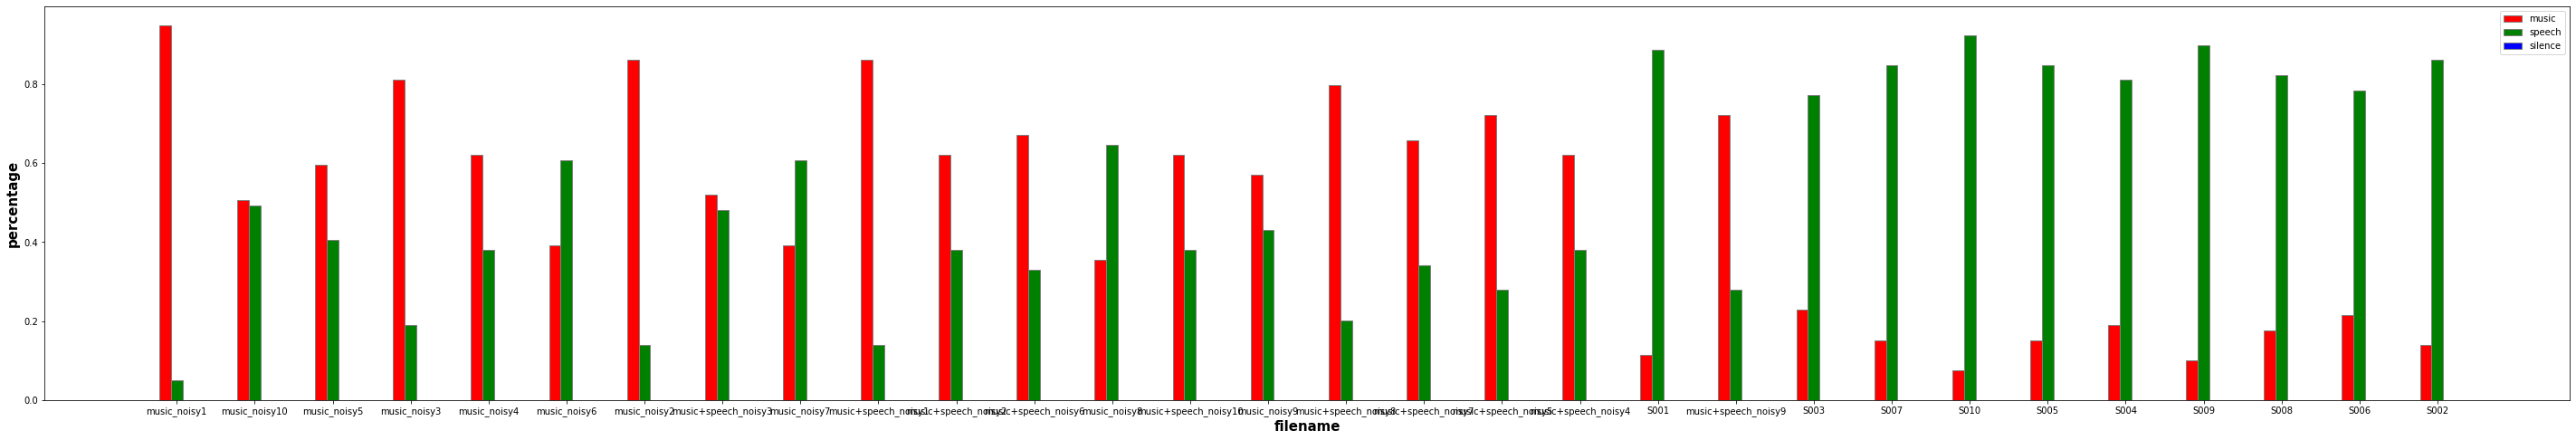

In [ ]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(50, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(m))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, m, color ='r', width = barWidth,
        edgecolor ='grey', label ='music')
plt.bar(br2, sp, color ='g', width = barWidth,
        edgecolor ='grey', label ='speech')
plt.bar(br3, si, color ='b', width = barWidth,
        edgecolor ='grey', label ='silence')
 
# Adding Xticks
plt.xlabel('filename', fontweight ='bold', fontsize = 15)
plt.ylabel('percentage', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(m))],n)
 
plt.legend()
plt.show()

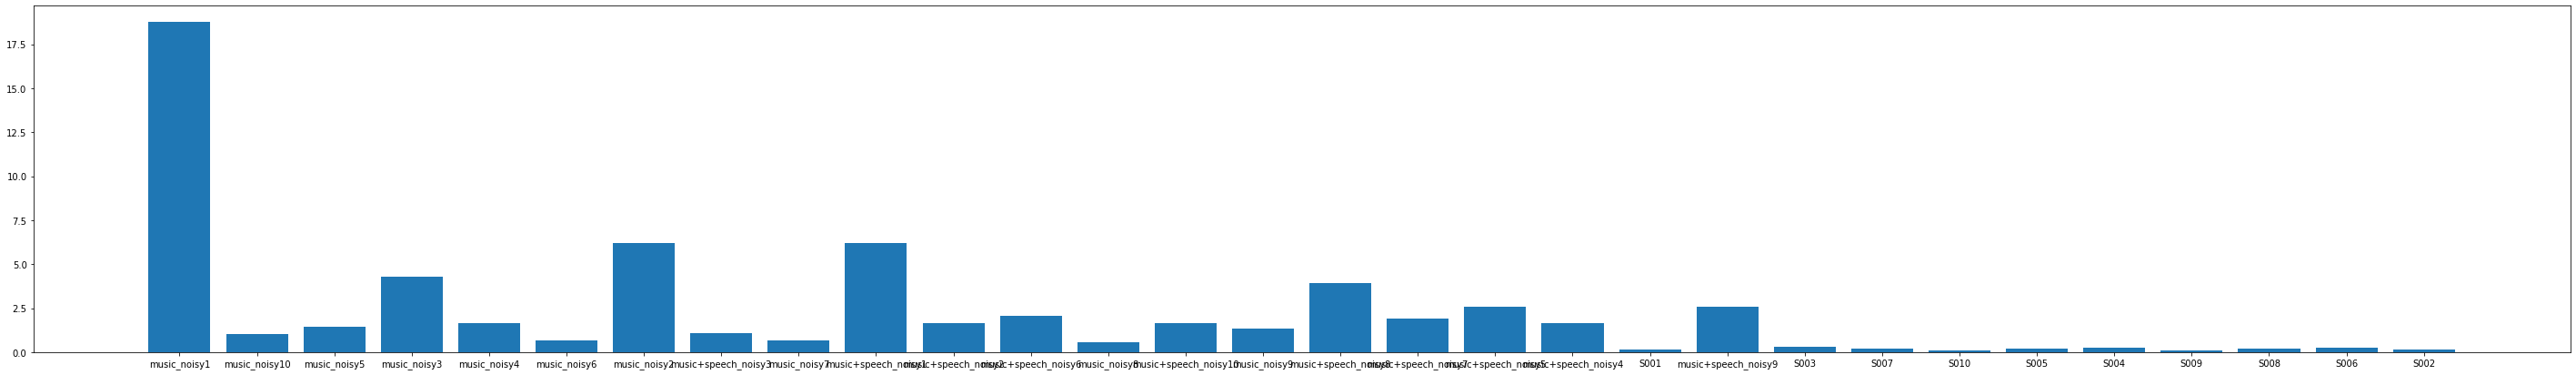

In [ ]:
plt.figure(figsize =(50, 7))
plt.bar(n,r)
plt.show()

In [ ]:
music_noisy = [np.max(r[:7]),np.min(r[:7])]
music_speech = [np.max(r[7:19]),np.min(r[7:19])]
speech = [np.max(r[21:]),np.min(r[21:])]

print("outliers: music_noisy:{}, speech:{}".format(r[20],r[19]))

print(music_noisy,music_speech,speech)

outliers: music_noisy:2.590909090909091, speech:0.1285714285714286
[18.75, 0.6458333333333333] [6.1818181818181825, 0.5490196078431373] [0.29508196721311475, 0.0821917808219178]
